In [1]:
%tensorflow_version 2.x


### Exploration + Experience Replay + свёрточная нейросеть для аппроксимации Q-функции

In [2]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.initializers import glorot_uniform
from keras import backend as K
from gym import wrappers

In [3]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Air Raid (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Alien.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying crazy_climber.bin from HC ROMS/BY ALPHABET (PAL)/A-G/REMAINING NTSC ORIGINALS/Crazy Climber.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/crazy_climber.bin
copying elevator_action.bin from HC ROMS/BY ALPHABET (PAL)/

In [4]:
env = gym.make('Pong-v0')

In [5]:
env.observation_space.shape

(210, 160, 3)

In [6]:
class DQNAgent:
  def __init__(self, episode, replay_buffer_size):
    self.replay_buffer = []
    self.replay_buffer_size = replay_buffer_size

    self.gamma = 0.99
    self.lr = 0.001 # learning rate

    self.epsilon = 1.0

    self.input_shape = (75, 80, 1)
    #self.input_shape=env.observation_space.shape

    self.n_outputs = 1
    #self.n_outputs = env.action_space.n

    self.adv = None
    self.q_model = self.build_model(self.input_shape, self.n_outputs)
    self.q_model.compile(loss=self.custom_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=self.  lr))

  def prepro(self, img):
    img = img[35:185]
    img = img[::2, ::2, 0]
    img[img == 144] = 0
    img[img == 109] = 0
    img[img != 0] = 1
    return img.astype(np.float)
  
  def custom_loss(self, y, aprob):
    y_true = y
    y_pred = aprob
    log_lik = K.log(y_true * (y_true - y_pred) + (1 - y_true) * (y_true + y_pred))
    return K.mean(log_lik * self.adv, keepdims=True)

  def build_model(self, input, shape):
    q_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='valid', 
                                 activation='relu', input_shape=self.input_shape),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='valid', 
                                 activation='relu'),
                                 tf.keras.layers.MaxPooling2D(pool_size=2),
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(256, activation='relu',
                                                       use_bias=False,
                                                       kernel_initializer=glorot_uniform(seed=42)),
                                   tf.keras.layers.Dense(self.n_outputs, activation='sigmoid',
                                                       use_bias=False,
                                                       kernel_initializer=glorot_uniform(seed=42))
    ])

    return q_model
    
  def discount_rewards(self, r):
    disc_r = np.zeros_like(r).astype(float)
    running_add = 0
    for t in reversed(range(len(r))):
      if r[t] != 0: running_add = 0
      running_add = running_add * self.gamma + r[t]
      disc_r[t] = running_add
    return disc_r

  def act(self, state):
    if np.random.rand() < self.epsilon:
      action = np.random.choice([2, 3], 1)[0]
    else:
      state = self.prepro(state)
      aprob = self.q_model.predict(state[None, ...])
      action = 2 if aprob > 0.5 else 3
    return action

  def remember(self, state, action, reward, next_state, done):
    item = (state, action, reward, next_state, done)
    self.replay_buffer.append(item)

  def get_target_label(self, action):
    y = 1.0 if action == 2 else 0.0
    return y

  def replay(self, batch_size):
    rewards = []
    for _, _, reward, _, _ in self.replay_buffer:
      rewards.append(reward)
    rewards = self.discount_rewards(rewards)

    idx = np.random.choice(self.replay_buffer_size, TRAIN_STEPS, replace=False)
    reward_batch = [rewards[i] for i in idx]

    state_batch, target_value_batch = [], []
    replay = [self.replay_buffer[i] for i in idx]
    for state, action, reward, next_state, done in replay:
      state = self.prepro(state)
      aprob = self.q_model.predict(state[None, ...])

      y = self.get_target_label(action)

      state_batch.append(state)
      target_value_batch.append(y)

    self.adv = np.array(reward_batch)
    self.adv = self.adv.mean()
    self.adv /= self.adv.std()
    self.adv = self.adv.squeeze()

    self.q_model.fit(np.array(state_batch), np.array(target_value_batch),
                      batch_size=batch_size, epochs=1, verbose=0)
    
    self.update_epsilon()
  
  def update_epsilon(self):
    self.epsilon = 1.0 - episode / NUM_EPISODES


In [20]:
outdir = '1'
env = wrappers.Monitor(env, directory=outdir, force=True)
env.seed(0)

[0, 592379725]

In [21]:
scores = []
MEAN_SCORES = []

BATCH_SIZE = 32
TARGET_WINDOW = 50

NUM_EPISODES = 1000 # число эпизодов для обучения
TRAIN_STEPS = 10
replay_buffer_size = BATCH_SIZE


for episode in range(NUM_EPISODES):
  #print(f'Episode = {episode}')
  state = env.reset()
  agent = DQNAgent(episode=episode, replay_buffer_size=replay_buffer_size)
  done = False
  total_reward = 0
  while not done:
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    agent.remember(state, action, reward, next_state, done)
    total_reward += reward
  else:
    if len(agent.replay_buffer) >= agent.replay_buffer_size:
      agent.replay(BATCH_SIZE)
      diff = len(agent.replay_buffer) - agent.replay_buffer_size
      agent.replay_buffer = agent.replay_buffer[diff:]
  scores.append(total_reward)
  if episode % 50 == 0 and len(scores) >= TARGET_WINDOW:
    mean_total_score = np.mean(scores[-TARGET_WINDOW:])
    MEAN_SCORES.append(mean_total_score)
    print('Episode {}, mean total reward {}'.format(episode, mean_total_score))

env.close() 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in double_scalars


Episode 50, mean total reward -20.4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in double_scalars


Episode 100, mean total reward -20.68


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in double_scalars


Episode 150, mean total reward -20.26
Episode 200, mean total reward -20.48


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in double_scalars


Episode 250, mean total reward -20.18
Episode 300, mean total reward -20.46


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in double_scalars


Episode 350, mean total reward -20.32
Episode 400, mean total reward -20.28
Episode 450, mean total reward -20.54
Episode 500, mean total reward -20.7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in double_scalars


Episode 550, mean total reward -20.52
Episode 600, mean total reward -20.38
Episode 650, mean total reward -20.46
Episode 700, mean total reward -20.32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in double_scalars


Episode 750, mean total reward -20.34
Episode 800, mean total reward -20.54
Episode 850, mean total reward -20.28
Episode 900, mean total reward -20.46
Episode 950, mean total reward -20.58


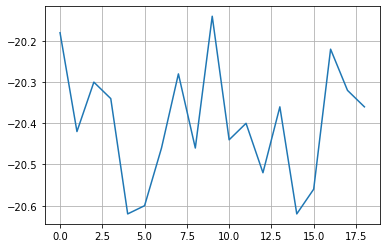

In [11]:
plt.plot(MEAN_SCORES)
plt.grid()